# Implementasi Transformer Dengan Numpy 

## Setup Awal

In [1]:
# Import Library
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Declare Hyperparameter
vocab_size = 1000
d_model = 512
seq_len = 10 
batch_size = 2
num_heads = 8
d_ff = 2048

## Implementasi Komponen

In [3]:
# Utilitas Dasar
def softmax(x):
    """Fungsi aktivasi softmax"""
    e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return e_x / np.sum(e_x, axis=-1, keepdims=True)

def create_causal_mask(seq_len):
    """Causal mask untuk decoder"""
    mask = np.triu(np.ones((1, 1, seq_len, seq_len)), k=1)
    return np.where(mask, -np.inf, 0)

In [4]:
# Lapisan Embedding & Positional Encoding
class TokenEmbedding:
    """Mengubah token integer menjadi vektor embedding"""
    def __init__(self, vocab_size, d_model):
        scale = 1 / np.sqrt(d_model)
        self.embedding_matrix = np.random.randn(vocab_size, d_model) * scale

    def forward(self, token_indices):
        return self.embedding_matrix[token_indices]
    
class PositionalEncoding:
    """Menambahkan informasi posisi ke embedding."""
    def __init__(self, seq_len, d_model):
        positions = np.arange(seq_len)[:, np.newaxis]
        div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
            
        pe = np.zeros((seq_len, d_model))
        pe[:, 0::2] = np.sin(positions * div_term)
        pe[:, 1::2] = np.cos(positions * div_term)
        self.pe = pe[np.newaxis, :, :] 

    def forward(self, x):
        return x + self.pe

In [5]:
# Lapisan Attention
def scaled_dot_product_attention(Q, K, V, mask=None):
    """Implementasi scaled dot product untuk attention"""
    d_k = Q.shape[-1]
    attention_scores = (Q @ K.swapaxes(-2, -1)) / np.sqrt(d_k)
    if mask is not None:
        attention_scores += mask
    attention_weights = softmax(attention_scores)
    output = attention_weights @ V
    return output, attention_weights

class MultiHeadAttention:
  """Implementasi multi-head attention"""
  def __init__(self, d_model, num_heads):
    self.d_model = d_model
    self.num_heads = num_heads
    self.d_k = d_model // num_heads

    scale = 1 / np.sqrt(d_model) # mencegah exploding gradients 
    self.W_q = np.random.randn(d_model, d_model) * scale
    self.W_k = np.random.randn(d_model, d_model) * scale
    self.W_v = np.random.randn(d_model, d_model) * scale
    self.W_o = np.random.randn(d_model, d_model) * scale
  
  def forward(self, x, mask=None):
    batch_size, seq_len, _ = x.shape

    # Proyeksi Linear
    Q = x @ self.W_q
    K = x @ self.W_k
    V = x @ self.W_v

    # Reshape untuk Multi-Head
    Q = Q.reshape(batch_size, seq_len, self.num_heads, self.d_k).swapaxes(1, 2)
    K = K.reshape(batch_size, seq_len, self.num_heads, self.d_k).swapaxes(1, 2)
    V = V.reshape(batch_size, seq_len, self.num_heads, self.d_k).swapaxes(1, 2)

    if mask is not None:
      batch_size, _, seq_len, _ = Q.shape
      mask = np.broadcast_to(mask, (batch_size, self.num_heads, seq_len, seq_len))
    
    attention_output, self.attention_weights = scaled_dot_product_attention(Q, K, V, mask)

    concatenated_output = attention_output.swapaxes(1, 2).reshape(batch_size, seq_len, self.d_model)
    output = concatenated_output @ self.W_o
    return output

In [6]:
# Lapisan LayerNorm & FFN
class LayerNormalization:
    """Implementasi layer normalization"""
    def __init__(self, d_model, epsilon=1e-5):
        self.epsilon = epsilon
        self.gamma = np.ones(d_model)
        self.beta = np.zeros(d_model)

    def forward(self, x):
        mean = np.mean(x, axis=-1, keepdims=True)
        std = np.std(x, axis=-1, keepdims=True)
        return self.gamma * (x - mean) / (std + self.epsilon) + self.beta
    
class FeedForwardNetwork:
    """Implementasi feed-forward network"""
    def __init__(self, d_model, d_ff):
        scale1 = 1 / np.sqrt(d_model)
        scale2 = 1 / np.sqrt(d_ff)
        
        self.W1 = np.random.randn(d_model, d_ff) * scale1
        self.b1 = np.zeros(d_ff)
        self.W2 = np.random.randn(d_ff, d_model) * scale2
        self.b2 = np.zeros(d_model)

    def relu(self, x):
        return np.maximum(0, x)
    
    def forward(self, x):
        return self.relu(x @ self.W1 + self.b1) @ self.W2 + self.b2

## Eksekusi Forward Pass

In [7]:
# Inisialisasi komponen
token_embedding_layer = TokenEmbedding(vocab_size, d_model)
positional_encoding_layer = PositionalEncoding(seq_len, d_model)
mha_layer = MultiHeadAttention(d_model, num_heads)
ffn_layer = FeedForwardNetwork(d_model, d_ff)
norm1 = LayerNormalization(d_model)
norm2 = LayerNormalization(d_model)
final_projection_layer = np.random.randn(d_model, vocab_size)

In [8]:
# Menjalankan Forward Pass
# Menyiapkan input dan mask
input_tokens = np.random.randint(0, vocab_size, size=(batch_size, seq_len))
mask = create_causal_mask(seq_len)
print(f"Bentuk Input Tokens: {input_tokens.shape}\n")

# Jalankan forward pass

# Langkah A: Embedding + Positional Encoding
x = token_embedding_layer.forward(input_tokens)
x = positional_encoding_layer.forward(x)
print(f"Bentuk setelah Embedding & Positional Encoding: {x.shape}")

# Langkah B: Transformer (Pre-Norm)
# Add & Norm + Multi-Head Attention
residual_1 = x
x_norm1 = norm1.forward(x)
attention_output = mha_layer.forward(x_norm1, mask)
x = residual_1 + attention_output
print(f"Bentuk setelah Multi-Head Attention: {x.shape}")

# Add & Norm + Feed-Forward Network
residual_2 = x
x_norm2 = norm2.forward(x)
ffn_output = ffn_layer.forward(x_norm2)
x = residual_2 + ffn_output
print(f"Bentuk setelah Feed-Forward Network: {x.shape}")

# Langkah C: Output Layer
logits = x @ final_projection_layer
probabilities = softmax(logits)
print(f"\nBentuk Logits Akhir: {logits.shape}")
print(f"Bentuk Probabilitas Akhir: {probabilities.shape}")

# Bukti Uji Softmax
next_token_prob = probabilities[:, -1, :]
print(f"\nBentuk Probabilitas Token Berikutnya: {next_token_prob.shape}")
for i in range(batch_size):
    sum_prob = np.sum(next_token_prob[i, :])
    print(f"Total Probabilitas untuk sekuens ke-{i+1}: {sum_prob:.5f}")

Bentuk Input Tokens: (2, 10)

Bentuk setelah Embedding & Positional Encoding: (2, 10, 512)
Bentuk setelah Multi-Head Attention: (2, 10, 512)
Bentuk setelah Feed-Forward Network: (2, 10, 512)

Bentuk Logits Akhir: (2, 10, 1000)
Bentuk Probabilitas Akhir: (2, 10, 1000)

Bentuk Probabilitas Token Berikutnya: (2, 1000)
Total Probabilitas untuk sekuens ke-1: 1.00000
Total Probabilitas untuk sekuens ke-2: 1.00000


## Visualisasi Attention

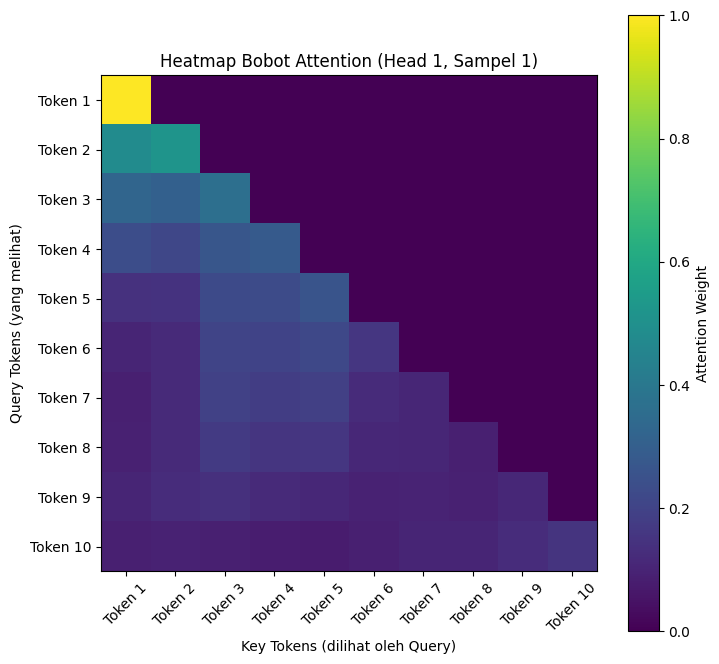

In [9]:
# Ambil bobot attention yang sudah disimpan di dalam mha_layer
attention_weights = mha_layer.attention_weights

# Pilih satu sampel dari batch untuk divisualisasikan
weights_to_plot = attention_weights[0, 0, :, :]

# Buat plot heatmap
fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.imshow(weights_to_plot, cmap='viridis')

ax.set_title('Heatmap Bobot Attention (Head 1, Sampel 1)')
ax.set_xlabel('Key Tokens (dilihat oleh Query)')
ax.set_ylabel('Query Tokens (yang melihat)')
fig.colorbar(cax, label='Attention Weight')

dummy_labels = [f'Token {i+1}' for i in range(seq_len)]
ax.set_xticks(np.arange(seq_len))
ax.set_yticks(np.arange(seq_len))
ax.set_xticklabels(dummy_labels, rotation=45)
ax.set_yticklabels(dummy_labels)

plt.show()